In [1]:

# Zachary Katz
# zachary_katz@mines.edu
# 04 June 2025

"""

Download ATL 11 granule if necessary
Extract example with multiple crossing tracks
"""

# Imports
import earthaccess
from pathlib import Path
import h5py
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, shape
import shapefile
import cartopy.crs as ccrs
from pyproj import CRS, Transformer
import re
from itertools import combinations

# User-defined path
data_path = './_data/ATL11'
gl_path = '/Users/zachary_katz/Research/Antarctica_Masks/scripps_antarctica_polygons_v1.shp'


In [2]:
data_path = './Ross_ATL11Crossovers.csv'
data = pd.read_csv(data_path)
data.head()

,lat,lon,time_1,time_2,height_1,height_2,quality_1,quality_2,cycle_1,cycle_2,rgt_1,rgt_2
0,-82.456237,161.456559,2019-12-01 10:07:50.652,2020-02-12 16:34:06.253,81.049355,81.252910,0,0,5,6,1000,732
1,-82.456237,161.456559,2020-02-12 16:34:06.253,2020-03-01 05:47:34.822,81.252910,81.423880,0,0,6,6,732,1000
2,-82.456237,161.456559,2020-03-01 05:47:34.822,2020-05-13 12:13:56.904,81.423880,81.418945,0,0,6,7,1000,732
3,-82.456237,161.456559,2020-08-12 07:53:42.146,2020-08-29 21:07:11.628,80.894030,81.543350,1,0,8,8,732,1000
4,-82.456237,161.456559,2020-08-29 21:07:11.628,2020-11-11 03:33:30.590,81.543350,81.472534,0,0,8,9,1000,732


In [7]:
def ll2xy(lon: list[float], lat: list[float]) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y).
    Can also take single floats.

    Parameters
    ----------
    lon: list[float]
         Geodetic longitude in EPSG:4326
    lat: list[float]
         Geodetic latitude in EPSG:4326

    Returns
    -------
    x: list[float]
       Antarctic Polar Stereographic (EPSG:3031) x
    y: list[float]
       Antarctic Polar Stereographic (EPSG:3031) y
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

In [8]:
# Cull by lat
data_culled = data.drop_duplicates(subset=['lon'],keep='first')

data_culled['x'], data_culled['y'] = ll2xy(data_culled['lon'], data_culled['lat'])

/var/folders/q8/gfrrq79j2dzfr1jycf0w8bhh0000gx/T/ipykernel_78921/100112136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_culled['x'], data_culled['y'] = ll2xy(data_culled['lon'], data_culled['lat'])
/var/folders/q8/gfrrq79j2dzfr1jycf0w8bhh0000gx/T/ipykernel_78921/100112136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_culled['x'], data_culled['y'] = ll2xy(data_culled['lon'], data_culled['lat'])


In [9]:
data_culled.head()

,lat,lon,time_1,time_2,height_1,height_2,quality_1,quality_2,cycle_1,cycle_2,rgt_1,rgt_2,x,y
0,-82.456237,161.456559,2019-12-01 10:07:50.652,2020-02-12 16:34:06.253,81.049355,81.25291,0,0,5,6,1000,732,261029.457787,-778173.567020
17,-82.455724,161.455433,2019-12-01 10:07:50.662,2020-02-12 16:34:06.244,81.873830,82.37022,0,0,5,6,1000,732,261062.555752,-778221.517953
35,-82.454697,161.453179,2019-12-01 10:07:50.679,2020-02-12 16:34:06.227,84.397170,83.41288,0,0,5,6,1000,732,261128.830935,-778317.524896
53,-82.454183,161.452051,2019-12-01 10:07:50.687,2020-02-12 16:34:06.587,84.419580,85.35554,0,0,5,6,1000,732,261161.991259,-778365.557712
69,-82.453668,161.450957,2019-12-01 10:07:50.697,2020-02-12 16:34:06.579,85.324320,85.67135,0,0,5,6,1000,732,261194.725598,-778413.846326


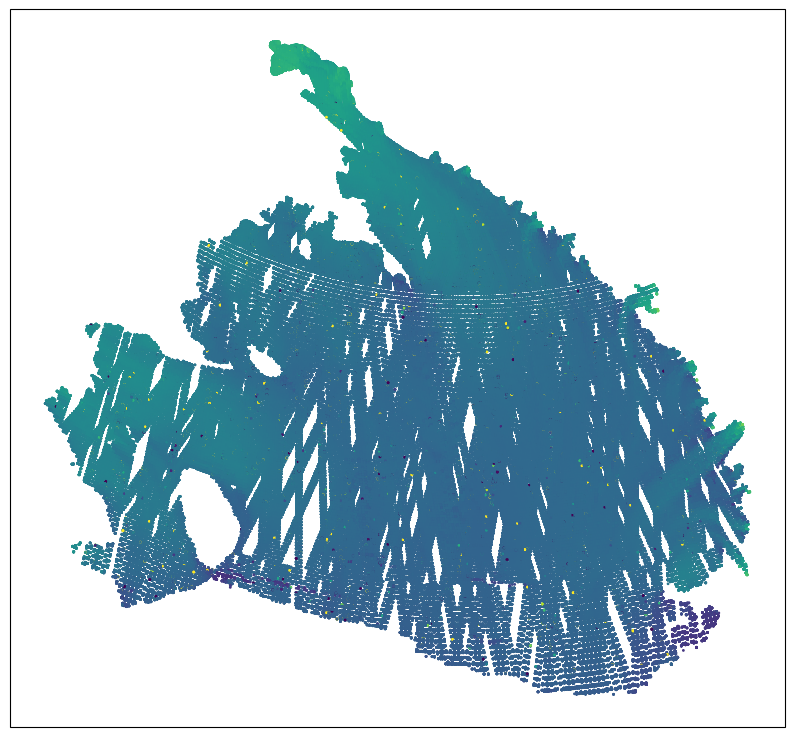

In [12]:
ed = 1000000
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ps71_projection},
)

ax.scatter(data_culled['x'][:ed],data_culled['y'][:ed],c=data_culled['height_1'][:ed],s=1,vmin=-100,vmax=200)

285336.9140252916 -1292835.4459196785


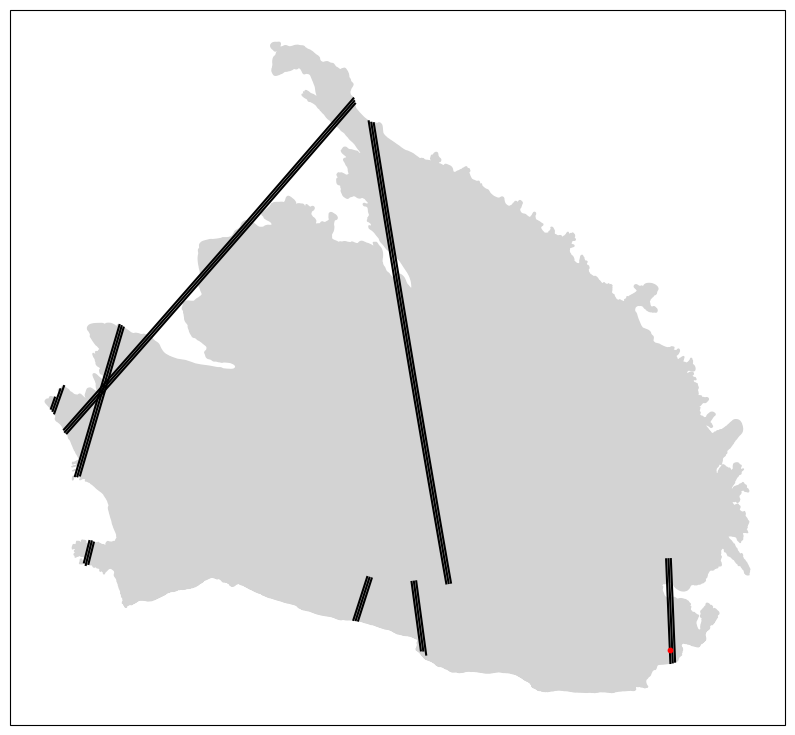

In [11]:
# Plot points in mask as sanity check
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ps71_projection},
)
plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)
for data in data_arr:
    ax.plot(data['x'][data['inside_mask']],data['y'][data['inside_mask']],color='black')

x,y = ll2xy(167.553988,-77.858628,)
print(x,y)
ax.scatter(x,y,color='red',s=10,zorder=10)

In [63]:
# Loop over each track and create crossover table
dfs = []
for data in data_arr[:]:
    i = 0
    for ref_pt in data['ref_pt'][data['inside_mask']]:

        mskx = (data['x_ref_pt'] == ref_pt) & (data['x_t_dt'] < 2e300)
        msk = (data['ref_pt'] == ref_pt)
        mskd_lat = data['lat'][msk]
        mskd_lon = data['lon'][msk]
        mskd_xlat = data['x_lat'][mskx]
        mskd_xlon = data['x_lon'][mskx]
        mskd_xt = data['x_time'][mskx]
        mskd_xcycle = data['x_cycle_number'][mskx]
        mskd_xrgt = data['x_rgt'][mskx]

        mskd_t = data['time'][msk]
        mskd_tdt = data['t_dt'][msk]
        msk_t = mskd_tdt < 2e300
        mskd_t = mskd_t[msk_t]

        mskd_h = data['h_corr'][msk]
        mskd_h = mskd_h[msk_t]
        mskd_xh = data['x_h_corr'][mskx]
        
        mskd_q = data['q_flag'][msk]
        mskd_q = mskd_q[msk_t]
        mskd_xq = data['x_q_flag'][mskx]

        msk_t = msk_t.flatten()
        mskd_cycle = data['cycle_number'][msk_t]

        mskd_lon = np.ones(len(mskd_t)) * mskd_lon
        mskd_lat = np.ones(len(mskd_t)) * mskd_lat

        match = re.search(r'ATL11_(\d{4})', str(data['filename']))
        mskd_rgt = np.ones(len(mskd_t),dtype=int) * int(match.group(1))
        
        #print(len(mskd_xlat),len(mskd_xlon),len(mskd_xt),len(mskd_xcycle),len(mskd_xh))
        #print(len(mskd_lat),len(mskd_lon),len(mskd_t),len(mskd_cycle),len(mskd_h[0]))
        if len(mskd_xlat) > 5:
            df1 = pd.DataFrame(
            {
                'lat': mskd_xlat,
                'lon': mskd_xlon,
                'time': mskd_xt,
                'height': mskd_xh,
                'q_flag': mskd_xq,
                'cycle_number': mskd_xcycle,
                'rgt': mskd_xrgt
            }
            )
            df2 = pd.DataFrame(
                {
                    'lat': mskd_lat,
                    'lon': mskd_lon,
                    'time': mskd_t,
                    'height': mskd_h,
                    'q_flag': mskd_q,
                    'cycle_number': mskd_cycle,
                    'rgt': mskd_rgt
                }
            )
            df = pd.concat([df1,df2], ignore_index=True)
            df = df.sort_values(by=['time']).reset_index(drop=True);
            dfs.append(df)


In [61]:
dfs[2]

,lat,lon,time,height,q_flag,cycle_number,rgt
0,-77.704387,167.683977,2019-06-18 04:01:08.541,-6.755488,0,3,1235
1,-77.704387,167.683977,2019-09-16 23:40:58.925,-6.824519,0,4,1235
2,-77.704387,167.683977,2019-11-25 09:34:30.927,-7.060673,0,5,908
3,-77.704387,167.683977,2019-12-16 19:20:47.397,-7.024527,0,5,1235
4,-77.704387,167.683977,2020-05-25 00:54:04.126,-6.705059,0,7,908
5,-77.704387,167.683977,2020-06-15 10:40:20.520,-7.537967,0,7,1235
6,-77.704387,167.683977,2020-09-14 06:20:08.523,-7.345633,0,8,1235
7,-77.704387,167.683977,2021-03-14 21:39:52.257,-7.554500,0,10,1235
8,-77.704387,167.683977,2021-05-23 07:33:23.976,-7.878996,0,11,908
9,-77.704387,167.683977,2021-06-13 17:19:42.624,-7.979585,0,11,1235


In [ ]:
# Generate all combos for laurie
from itertools import combinations

combined_rows = []
for iter, df in enumerate(dfs[:]):
    #print(iter)
    # Iterate over all unique pairs of rows
    rows = df.reset_index()
    
    lat_arr = rows['lat'].values
    lon_arr = rows['lon'].values
    time_arr = rows['time'].values
    height_arr = rows['height'].values
    q_flag_arr = rows['q_flag'].values
    cycle_arr = rows['cycle_number'].values
    rgt_arr = rows['rgt'].values

    pairs = list(combinations(range(len(rows)), 2))

    # Prepare list to store new rows
    for i, j in pairs:
        new_row = [
            lat_arr[i],
            lon_arr[i],
            time_arr[i],
            time_arr[j],
            height_arr[i],
            height_arr[j],
            q_flag_arr[i],
            q_flag_arr[j],
            cycle_arr[i],
            cycle_arr[j],
            rgt_arr[i],
            rgt_arr[j]
        ]
        combined_rows.append(new_row)

    columns = [
    'lat', 'lon', 'time_1', 'time_2', 'height_1', 'height_2',
    'quality_1', 'quality_2', 'cycle_1', 'cycle_2', 'rgt_1', 'rgt_2'
]

print(len(combined_rows))
laurie_df = pd.DataFrame(combined_rows[:], columns=columns)
print(len(laurie_df))
laurie_df.head()

In [69]:
i = 1
laurie_df.to_csv(f"Ross_ATL11Crossovers_{i}", index=False)

In [25]:
import glob
dfs = []
files = glob.glob("./FullCrossovers/Ross_*")
for file in files:
    print(file)
    dfs.append(pd.read_csv(file))

./FullCrossovers/Ross_ATL11Crossovers_59
./FullCrossovers/Ross_ATL11Crossovers_57
./FullCrossovers/Ross_ATL11Crossovers_50
./FullCrossovers/Ross_ATL11Crossovers_6
./FullCrossovers/Ross_ATL11Crossovers_1
./FullCrossovers/Ross_ATL11Crossovers_8
./FullCrossovers/Ross_ATL11Crossovers_35
./FullCrossovers/Ross_ATL11Crossovers_32
./FullCrossovers/Ross_ATL11Crossovers_51
./FullCrossovers/Ross_ATL11Crossovers_56
./FullCrossovers/Ross_ATL11Crossovers_58
./FullCrossovers/Ross_ATL11Crossovers_33
./FullCrossovers/Ross_ATL11Crossovers_34
./FullCrossovers/Ross_ATL11Crossovers_9
./FullCrossovers/Ross_ATL11Crossovers_0
./FullCrossovers/Ross_ATL11Crossovers_7
./FullCrossovers/Ross_ATL11Crossovers_27
./FullCrossovers/Ross_ATL11Crossovers_18
./FullCrossovers/Ross_ATL11Crossovers_20
./FullCrossovers/Ross_ATL11Crossovers_16
./FullCrossovers/Ross_ATL11Crossovers_29
./FullCrossovers/Ross_ATL11Crossovers_11
./FullCrossovers/Ross_ATL11Crossovers_45
./FullCrossovers/Ross_ATL11Crossovers_42
./FullCrossovers/Ross_

In [10]:
one_row_dfs = []
for laurie_df in dfs:
    one_row_per_lat = laurie_df.drop_duplicates(subset='lat', keep='first')
    one_row_dfs.append(one_row_per_lat)

[261029.45778745 261062.55575165 261128.83093544 ... -48550.86946706
 -48524.90101284 -48498.92921403] [-778173.56702022 -778221.51795279 -778317.52489584 ... -597413.30621377
 -597361.25067314 -597309.1969089 ]
[-20960.41901424 -20948.67535769 -20935.93674045 ... 190363.65202692
 190382.07560366 190400.48507211] [-1196366.6708674  -1196309.21004056 -1196252.07485757 ...
 -1348211.65157639 -1348267.47268421 -1348323.27674741]
[ 11266.3300354   11287.27227294  11329.19695938 ... 388538.50264254
 388568.25386839 388627.61456192] [ -632794.7435867   -632849.01606802  -632957.60808415 ...
 -1126168.21869575 -1126218.71884618 -1126319.74807934]
[125240.91371445 125245.61878634 125261.13738857 ...  65933.91833225
  65942.26200024  66652.48193798] [-1189930.22417499 -1189871.80459479 -1189696.6272656  ...
 -1202990.40142068 -1202932.38748723 -1198000.91073457]
[-204212.15050639 -204170.72276292 -204156.10354483 ...  339377.98953635
  339403.49670358  339428.9448373 ] [-1178736.1795158  -11786

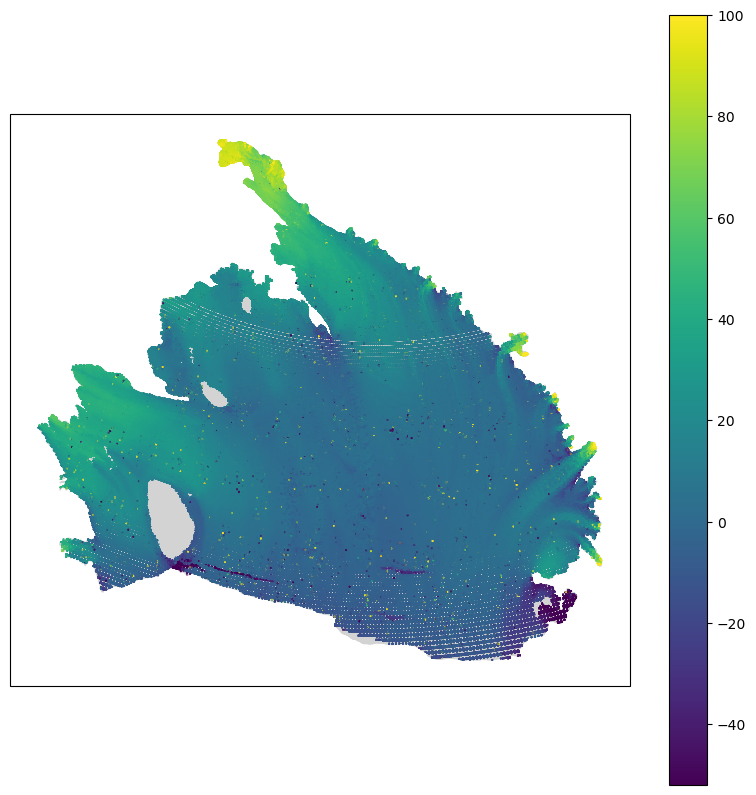

In [12]:

hmin = -52
hmax = 100
# Plot points in mask as sanity check
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ps71_projection},
)
plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)

for one_row_per_lat in one_row_dfs:
    x,y = ll2xy(one_row_per_lat['lon'],one_row_per_lat['lat'])
    print(x,y)
    col = ax.scatter(x,y,s=0.1,zorder=10,c=one_row_per_lat['height_1'],cmap='viridis',vmin=hmin,vmax=hmax)

fig.colorbar(col)

#ax.set_xlim(-600000,-500000)
#ax.set_ylim(-1000000,-900000)

In [27]:
# Laurie only wants crossovers with < 90 days
csv_index = 0
filtered_dfs = []
for df in dfs:
    df['time_1'] = pd.to_datetime(df['time_1'])
    df['time_2'] = pd.to_datetime(df['time_2'])

    time_diff = (df['time_1'] - df['time_2']).abs().dt.days

    filtered_df = df[time_diff < 90]
    print(len(filtered_df))
    filtered_dfs.append(filtered_df)

590406
1455621
825092
1022341
808310
1087083
1168180
983521
921375
787386
1288088
800352
1371033
964093
807058
886643
881167
917940
1387894
1262323
892350
1237441
628803
845141
1054144
1126057
1158698
1050126
480297
694967
1415070
1281601
906671
938781
872784
1071761
616694
800966
819564
1580848
706858
1030930
577767
1031732
784717
646140
1190358
957367
632837
1006775
1240977
378761
795174
1101404
981289
1477125
1296738
869533
1149205
507554


In [28]:
combined_df = pd.concat(filtered_dfs, ignore_index=True)
print("Saving Dataframe")
combined_df.to_csv(f"Ross_ATL11Crossovers.csv", index=False)

Saving Dataframe


In [29]:
len(combined_df)

58051911